# The Packages

In [1]:
import numpy as np
import pandas as pd
import os
import gc
import datetime
import warnings

In [2]:

import statsmodels.api as sm
from datetime import date

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
import tensorflow as tf
import math 
# keras = tf.keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from tensorflow.keras import losses
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.utils import plot_model

In [5]:
tf.__version__

'2.10.1'

In [6]:
# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_style("darkgrid")
sns.color_palette("mako", as_cmap=True)
import plotly.express as px


In [7]:
# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

# Utility Functions

In [8]:
def plotSeries(time, series, lab,form='-'):
    plt.plot(time, series, form, label=lab)
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid(True)

In [9]:
def plotEvaluation(testData, predData, columns):
    testDf = pd.DataFrame(testData, columns = columns)
    predDf = pd.DataFrame(predData, columns = columns)
    plt.figure(figsize=(15,5))
    plt.plot(testDf.Close, label='Real')
    plt.plot(predDf.Close, label='Prediction')

    plt.legend(loc="best")
    #for saving figures
    plt.show()

# The Data

In [10]:
wfc = pd.read_csv('Dataset/WFC Daily1.csv')

In [11]:
wfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,20.16,20.19,19.00,19.56,10.44,9037000
1,2000-01-04,18.62,18.84,18.00,18.59,9.92,15237200
2,2000-01-05,18.50,18.88,18.03,18.41,9.82,8228200
3,2000-01-06,18.53,19.50,18.47,19.22,10.25,8326800
4,2000-01-07,19.62,19.84,19.28,19.56,10.44,7711200


In [12]:
wfc.Date.dtype

dtype('O')

In [13]:
wfc['Date'] = pd.to_datetime(wfc['Date'])
#wfc.set_index(['Date'],inplace=True)

In [14]:
wfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,20.16,20.19,19.00,19.56,10.44,9037000
1,2000-01-04,18.62,18.84,18.00,18.59,9.92,15237200
2,2000-01-05,18.50,18.88,18.03,18.41,9.82,8228200
3,2000-01-06,18.53,19.50,18.47,19.22,10.25,8326800
4,2000-01-07,19.62,19.84,19.28,19.56,10.44,7711200


In [15]:
wfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5754 entries, 0 to 5753
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5754 non-null   datetime64[ns]
 1   Open       5754 non-null   float64       
 2   High       5754 non-null   float64       
 3   Low        5754 non-null   float64       
 4   Close      5754 non-null   float64       
 5   Adj Close  5754 non-null   float64       
 6   Volume     5754 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 314.8 KB


In [16]:
wfc.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00
mean,36.38,36.78,35.98,36.38,28.01,24313450.19
std,11.74,11.77,11.73,11.75,12.85,26705062.78
min,8.65,8.94,7.80,8.12,5.76,1774000.00
25%,26.71,27.20,26.25,26.74,18.01,10091200.00
50%,32.65,33.13,32.25,32.64,23.18,17086600.00
75%,47.75,48.19,47.33,47.79,41.58,29145250.00
max,65.89,66.31,65.66,65.93,57.96,478736600.00


In [17]:
correlation = wfc.corr ()  
correlation. style.background_gradient ()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999324,0.999274,0.998754,0.965403,-0.184389
High,0.999324,1.000000,0.998796,0.999323,0.967945,-0.169457
Low,0.999274,0.998796,1.000000,0.999303,0.963519,-0.199335
Close,0.998754,0.999323,0.999303,1.000000,0.966149,-0.183272
Adj Close,0.965403,0.967945,0.963519,0.966149,1.000000,-0.080189
Volume,-0.184389,-0.169457,-0.199335,-0.183272,-0.080189,1.000000


In [18]:
#Dropping Volume for Clearer Scale

# The Split

In [19]:
min_date = wfc.Date.min()
max_date = wfc.Date.max()
print("Min:", min_date, "Max:", max_date)

Min: 2000-01-03 00:00:00 Max: 2022-11-11 00:00:00


In [20]:
train_percent = .75
valid_percent = .12

time_between = max_date - min_date

train_cutoff = min_date + train_percent*time_between
valid_cutoff = min_date + (train_percent + valid_percent)*time_between

print("Training Cutoff Date: {:s}".format(str(train_cutoff)))
print("Validation Cutoff Date: {:s}".format(str(valid_cutoff)))

Training Cutoff Date: 2017-02-23 00:00:00
Validation Cutoff Date: 2019-11-21 18:14:24


In [21]:
train_df = wfc[wfc.Date <= train_cutoff]
valid_df = wfc[(wfc.Date > train_cutoff) & (wfc.Date <= valid_cutoff)]
test_df = wfc[wfc.Date > valid_cutoff]


In [22]:
print("Dataset shape: {:s}".format(str(wfc.shape)))
print("Train dataset shape: {:s}".format(str(train_df.shape)))
print("Vaid dataset shape: {:s}".format(str(valid_df.shape)))
print("Test dataset shape: {:s}".format(str(test_df.shape)))

Dataset shape: (5754, 7)
Train dataset shape: (4313, 7)
Vaid dataset shape: (692, 7)
Test dataset shape: (749, 7)


# Stock Price Graph

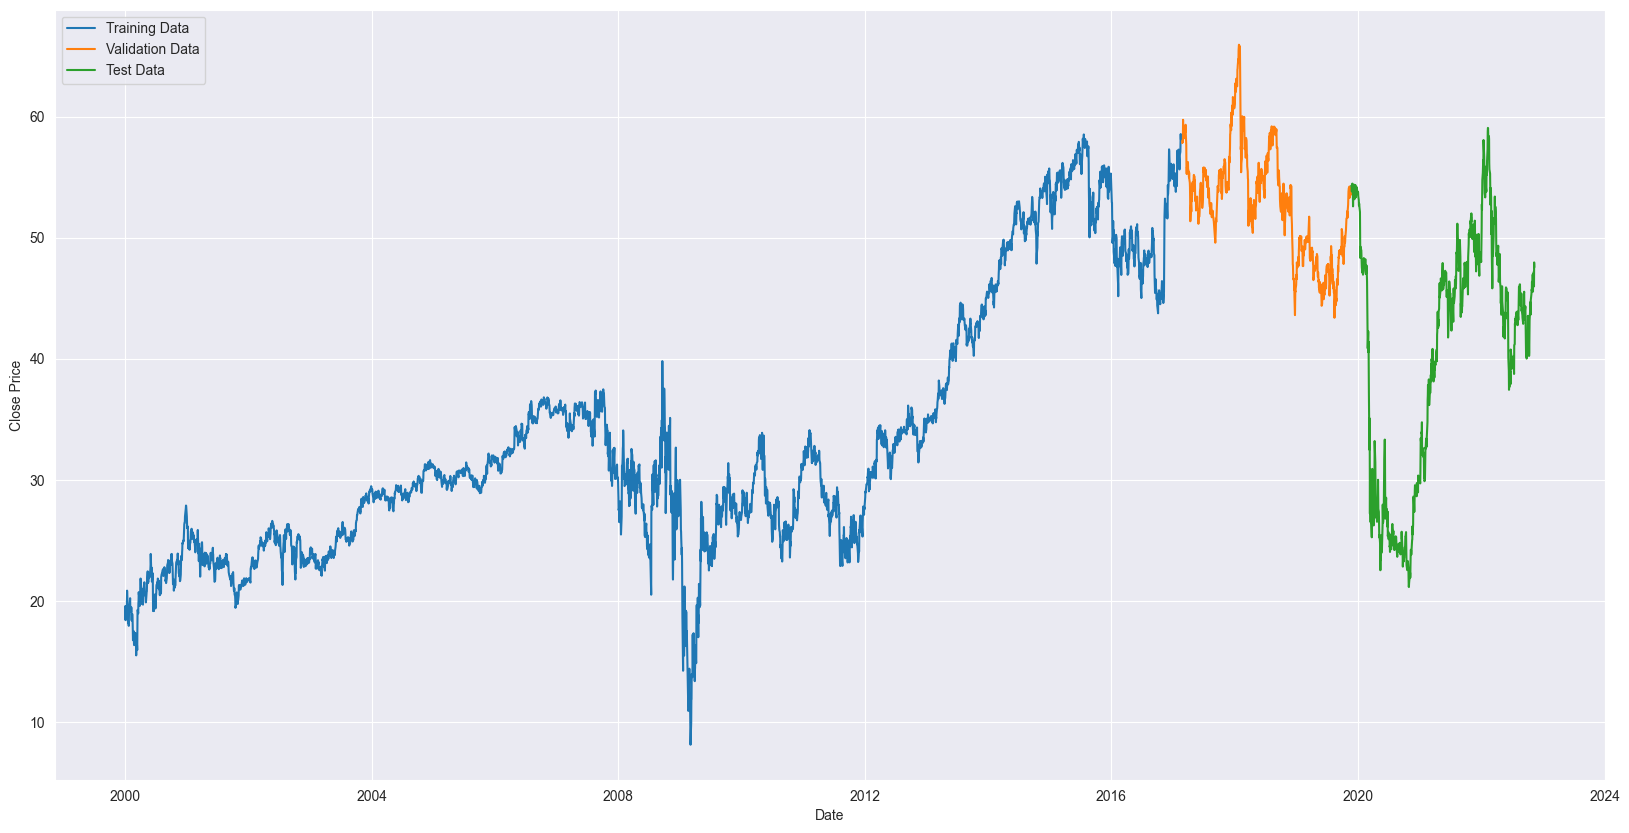

In [23]:
plotSeries(train_df.Date, train_df.Close, "Training Data")
plotSeries(valid_df.Date, valid_df.Close, "Validation Data")
plotSeries(test_df.Date, test_df.Close, "Test Data")
plt.legend(loc='upper left')

In [24]:
train_df.set_index(['Date'],inplace=True)
test_df.set_index(['Date'],inplace=True)
valid_df.set_index(['Date'],inplace=True)

In [25]:
scaler = MinMaxScaler()

trainNorm = scaler.fit_transform(train_df.values)
testNorm = scaler.transform(test_df.values)
validNorm = scaler.transform(valid_df.values)

trainNormDf = pd.DataFrame(trainNorm, columns=train_df.columns)
testNormDf = pd.DataFrame(testNorm, columns=test_df.columns)
validNormDf = pd.DataFrame(validNorm, columns=valid_df.columns)


In [26]:
def splitSequence(sequence, look_back, forecast_horizon):
    X, y = list(), list()
    for i in range(len(sequence)): 
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
            break
        seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [27]:
LOOK_BACK = 24
FORECAST_RANGE = 5
n_features = len(trainNormDf.columns)

In [28]:
#Add valid df
Xtrain, Ytrain = splitSequence(trainNormDf, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
Xvalid, Yvalid = splitSequence(validNormDf, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
Xtest, Ytest = splitSequence(testNormDf, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)

In [29]:
print(Xtrain.shape)
print(Ytrain.shape)
print(Xvalid.shape)
print(Yvalid.shape)
print(Xtest.shape)
print(Ytest.shape)

(4285, 24, 6)
(4285, 5, 6)
(664, 24, 6)
(664, 5, 6)
(721, 24, 6)
(721, 5, 6)


In [30]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse

In [65]:
def plotMAPEperEpoch(testData, predData):
    y_test_inverse_time_step  = testData.reshape(int(testData.shape[0]/FORECAST_RANGE), \
                                                      FORECAST_RANGE, testData.shape[-1])
    yhat_inverse_time_step = predData.reshape(int(predData.shape[0]/FORECAST_RANGE), \
                                                  FORECAST_RANGE, predData.shape[-1])
    # yhat_inverse_time_step and y_test_inverse_time_step are both same dimension.
    time_step_list_yhat = [[] for i in range(FORECAST_RANGE)]
    time_step_list_y_test = [[] for i in range(FORECAST_RANGE)]
    for i in range(0, yhat_inverse_time_step.shape[0]):
        for j in range(0, yhat_inverse_time_step.shape[1]):
            time_step_list_yhat[j].append(list(yhat_inverse_time_step[i][j]))
            time_step_list_y_test[j].append(list(y_test_inverse_time_step[i][j]))
    yhat_time_step = np.array(time_step_list_yhat)
    yhat_time_step = yhat_time_step.reshape(yhat_time_step.shape[0], -1)
    y_test_time_step = np.array(time_step_list_y_test)
    y_test_time_step = y_test_time_step.reshape(y_test_time_step.shape[0], -1)
    # plotting
    mape_list = []
    for i in range(0, FORECAST_RANGE):
        mape = mape_(y_test_time_step[i], yhat_time_step[i])
        print(mape)
        mape_list.append(mape)
    plt.plot(range(0, FORECAST_RANGE), mape_list, marker='o')
    plt.xticks((range(0, FORECAST_RANGE)))
    plt.xlabel('Forecast Range')
    plt.ylabel('MAPE')
    

In [70]:
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae)
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse)
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape)
    

In [33]:
mse_ = tf.keras.losses.MeanSquaredError()
mae_ = tf.keras.losses.MeanAbsoluteError()
mape_ = tf.keras.losses.MeanAbsolutePercentageError()
# mae = mae_(y_test_inverse,yhat_inverse)
# # print('mae:', mae)
# mse = mse_(y_test_inverse,yhat_inverse)
# # print('mse:', mse)
# mape = mape_(y_test_inverse,yhat_inverse)
# # print('mape:', mape)

In [34]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Encoder Decoder Model

In [35]:
tf.keras.backend.clear_session()
model_enc_dec = tf.keras.Sequential()

In [36]:
# WARNING:tensorflow:Layer lstm will not use cuDNN kernels since
# it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
model_enc_dec.add(LSTM(100, input_shape=(LOOK_BACK, n_features)))
model_enc_dec.add(RepeatVector(FORECAST_RANGE))
model_enc_dec.add(LSTM(100, return_sequences=True))
model_enc_dec.add(TimeDistributed(Dense(n_features)))


In [37]:
lrSchedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8*10**(epoch/20))
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, restore_best_weights=True)


In [38]:
optimizer = Adam(1e-3)
model_enc_dec.compile(loss=tf.keras.losses.MeanSquaredError(),
             optimizer = optimizer,
             metrics = ["mae"])


In [39]:
history = model_enc_dec.fit(Xtrain,Ytrain,batch_size=128, epochs=500, callbacks=[lrSchedule, earlyStop])

Epoch 1/500
34/34 [==============================] - 5s 13ms/step - loss: 0.2130 - mae: 0.3869 - lr: 1.0000e-08
Epoch 2/500
34/34 [==============================] - 0s 11ms/step - loss: 0.2130 - mae: 0.3869 - lr: 1.1220e-08
Epoch 3/500
34/34 [==============================] - 0s 13ms/step - loss: 0.2129 - mae: 0.3869 - lr: 1.2589e-08
Epoch 4/500
34/34 [==============================] - 0s 13ms/step - loss: 0.2129 - mae: 0.3869 - lr: 1.4125e-08
Epoch 5/500
34/34 [==============================] - 0s 13ms/step - loss: 0.2129 - mae: 0.3869 - lr: 1.5849e-08
Epoch 6/500
34/34 [==============================] - 0s 12ms/step - loss: 0.2129 - mae: 0.3868 - lr: 1.7783e-08
Epoch 7/500
34/34 [==============================] - 0s 12ms/step - loss: 0.2129 - mae: 0.3868 - lr: 1.9953e-08
Epoch 8/500
34/34 [==============================] - 0s 12ms/step - loss: 0.2128 - mae: 0.3868 - lr: 2.2387e-08
Epoch 9/500
34/34 [==============================] - 0s 13ms/step - loss: 0.2128 - mae: 0.3868 - lr: 2.5

34/34 [==============================] - 0s 13ms/step - loss: 0.0069 - mae: 0.0600 - lr: 3.9811e-05
Epoch 74/500
34/34 [==============================] - 0s 12ms/step - loss: 0.0052 - mae: 0.0532 - lr: 4.4668e-05
Epoch 75/500
34/34 [==============================] - 0s 12ms/step - loss: 0.0043 - mae: 0.0487 - lr: 5.0119e-05
Epoch 76/500
34/34 [==============================] - 0s 13ms/step - loss: 0.0037 - mae: 0.0454 - lr: 5.6234e-05
Epoch 77/500
34/34 [==============================] - 0s 12ms/step - loss: 0.0033 - mae: 0.0425 - lr: 6.3096e-05
Epoch 78/500
34/34 [==============================] - 0s 12ms/step - loss: 0.0029 - mae: 0.0398 - lr: 7.0795e-05
Epoch 79/500
34/34 [==============================] - 0s 11ms/step - loss: 0.0026 - mae: 0.0372 - lr: 7.9433e-05
Epoch 80/500
34/34 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0349 - lr: 8.9125e-05
Epoch 81/500
34/34 [==============================] - 0s 12ms/step - loss: 0.0021 - mae: 0.0326 - lr: 1.0000e

34/34 [==============================] - 0s 12ms/step - loss: 0.0399 - mae: 0.1504 - lr: 0.1585
Epoch 146/500
34/34 [==============================] - 0s 12ms/step - loss: 0.0405 - mae: 0.1501 - lr: 0.1778
Epoch 147/500
34/34 [==============================] - 0s 12ms/step - loss: 0.0390 - mae: 0.1470 - lr: 0.1995
Epoch 148/500
34/34 [==============================] - 0s 13ms/step - loss: 0.0420 - mae: 0.1534 - lr: 0.2239
Epoch 149/500
34/34 [==============================] - 0s 12ms/step - loss: 0.0395 - mae: 0.1486 - lr: 0.2512
Epoch 150/500
34/34 [==============================] - 0s 13ms/step - loss: 0.0389 - mae: 0.1489 - lr: 0.2818
Epoch 151/500
34/34 [==============================] - 0s 13ms/step - loss: 0.0436 - mae: 0.1578 - lr: 0.3162
Epoch 152/500
34/34 [==============================] - 0s 12ms/step - loss: 0.0469 - mae: 0.1660 - lr: 0.3548
Epoch 153/500
34/34 [==============================] - 0s 13ms/step - loss: 0.0690 - mae: 0.2076 - lr: 0.3981
Epoch 154/500
34/34 [===

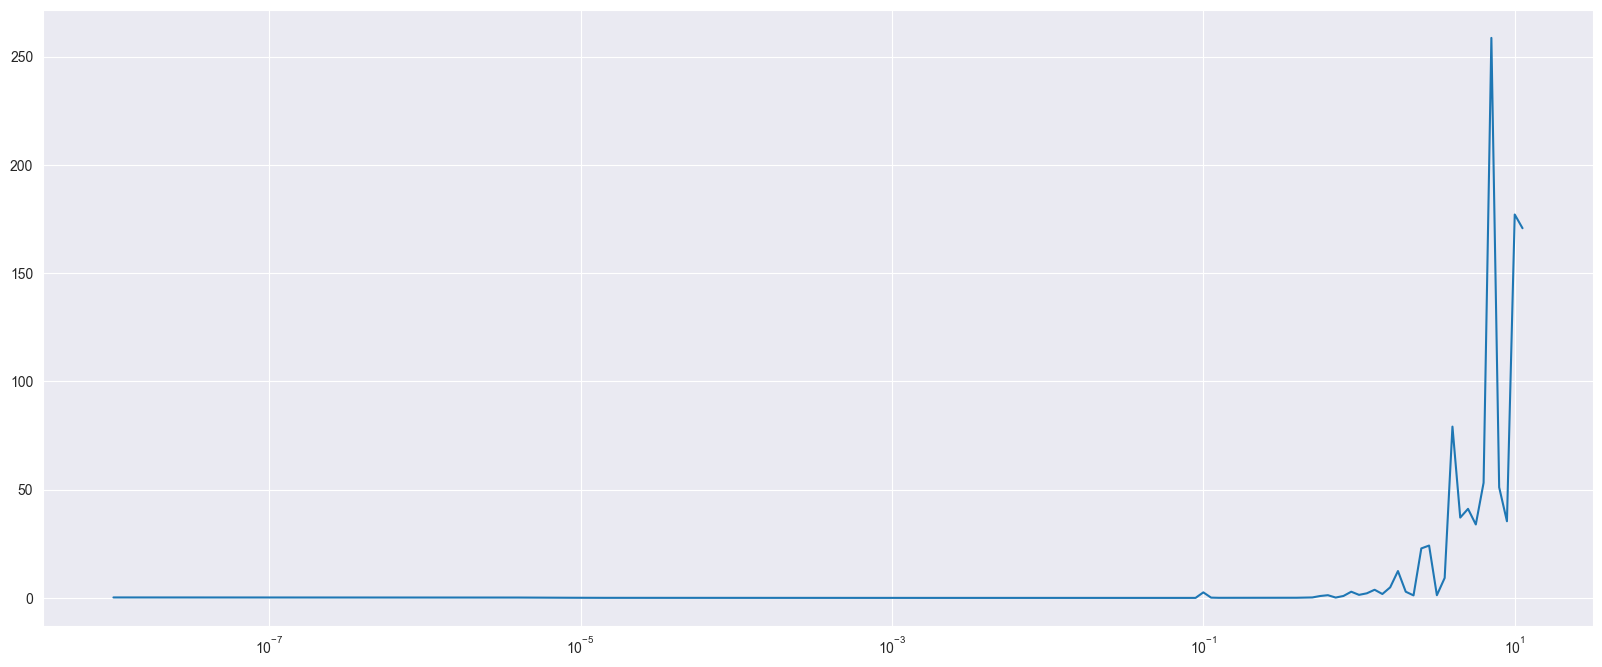

In [41]:
plt.figure(figsize=(20,8))
plt.semilogx(history.history["lr"], history.history["loss"])

(1e-08, 0.1, 0.0, 30.0)

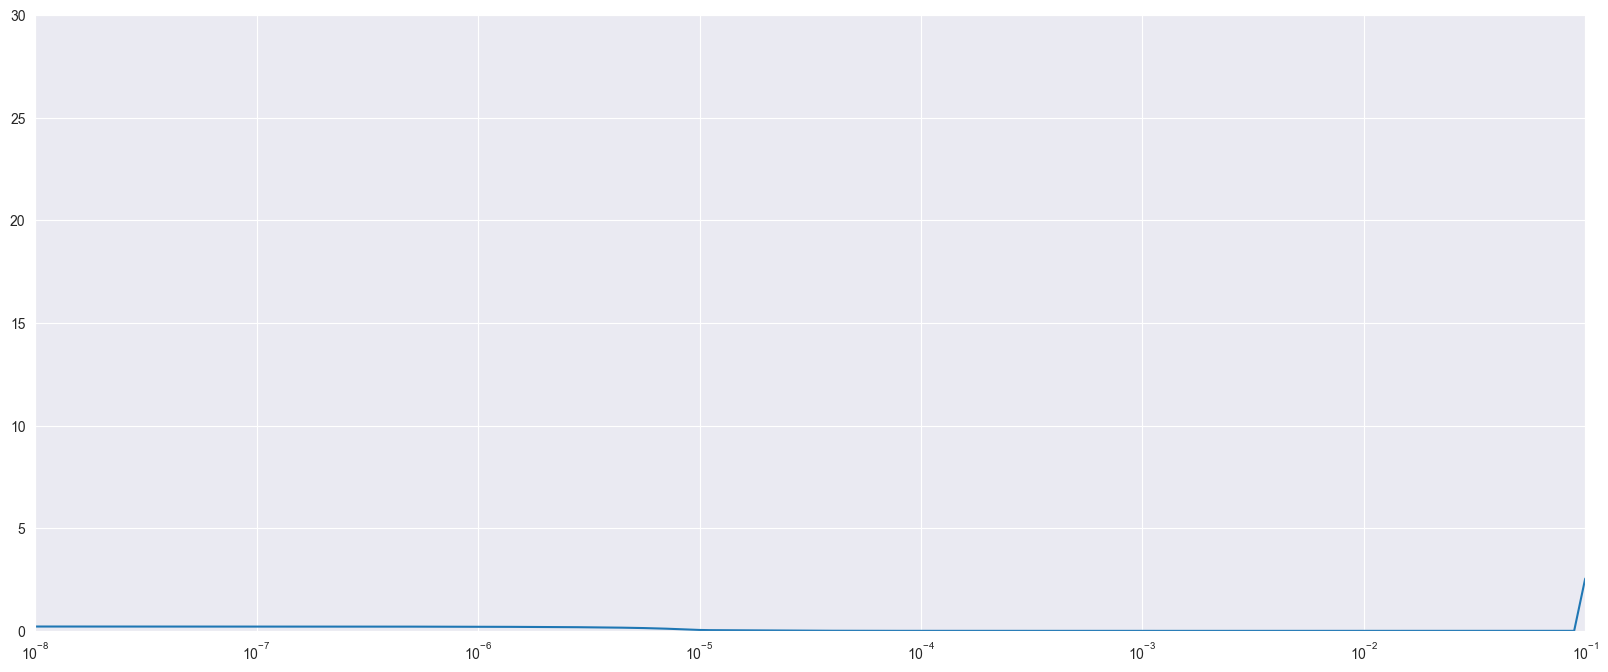

In [43]:
plt.figure(figsize=(20,8))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 30])

## Final Model

In [44]:
model_enc_dec.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=Adam(3e-2),
              metrics=['mae'])

In [45]:
# plot_model(model=model_enc_dec, show_shapes=True)

In [46]:
log_dir = "logs\\" + datetime.datetime.now().strftime("%d-%m-%Y_%H%M%S")
# model_path = ""
tensorboard_callback = [
#                         tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
#                         ModelCheckpoint(model_path, verbose=1, save_best_only=True),
                        ReduceLROnPlateau(monitor='val_mae', factor=0.3,patience=5, min_lr=1e-6, verbose=1),
#                         CSVLogger(csv_path),
                        TensorBoard(),
                        EarlyStopping(monitor= "val_mae", patience=10, restore_best_weights=True)
                       ]

In [47]:
history = model_enc_dec.fit(Xtrain, Ytrain,batch_size=128, epochs=100, verbose=1,validation_data=(Xvalid, Yvalid), \
                            callbacks=tensorboard_callback)

Epoch 1/100
34/34 [==============================] - 5s 44ms/step - loss: 0.0332 - mae: 0.1052 - val_loss: 0.0059 - val_mae: 0.0608 - lr: 0.0300
Epoch 2/100
34/34 [==============================] - 0s 14ms/step - loss: 0.0011 - mae: 0.0229 - val_loss: 0.0017 - val_mae: 0.0303 - lr: 0.0300
Epoch 3/100
34/34 [==============================] - 0s 14ms/step - loss: 8.1040e-04 - mae: 0.0190 - val_loss: 0.0020 - val_mae: 0.0310 - lr: 0.0300
Epoch 4/100
34/34 [==============================] - 0s 14ms/step - loss: 7.5123e-04 - mae: 0.0187 - val_loss: 0.0019 - val_mae: 0.0330 - lr: 0.0300
Epoch 5/100
34/34 [==============================] - 0s 14ms/step - loss: 8.3535e-04 - mae: 0.0204 - val_loss: 0.0022 - val_mae: 0.0322 - lr: 0.0300
Epoch 6/100
34/34 [==============================] - 0s 14ms/step - loss: 6.9163e-04 - mae: 0.0176 - val_loss: 0.0017 - val_mae: 0.0302 - lr: 0.0300
Epoch 7/100
34/34 [==============================] - 0s 13ms/step - loss: 6.6819e-04 - mae: 0.0172 - val_loss: 0.0

Epoch 52/100
34/34 [==============================] - 0s 13ms/step - loss: 4.6781e-04 - mae: 0.0127 - val_loss: 7.8397e-04 - val_mae: 0.0213 - lr: 8.1000e-04
Epoch 53/100
34/34 [==============================] - 0s 15ms/step - loss: 4.6805e-04 - mae: 0.0127 - val_loss: 8.0077e-04 - val_mae: 0.0213 - lr: 8.1000e-04
Epoch 54/100
34/34 [==============================] - 0s 14ms/step - loss: 4.6733e-04 - mae: 0.0127 - val_loss: 8.8053e-04 - val_mae: 0.0224 - lr: 8.1000e-04
Epoch 55/100
34/34 [==============================] - 0s 14ms/step - loss: 4.6593e-04 - mae: 0.0127 - val_loss: 8.0229e-04 - val_mae: 0.0212 - lr: 8.1000e-04
Epoch 56/100
34/34 [==============================] - 0s 14ms/step - loss: 4.6548e-04 - mae: 0.0127 - val_loss: 8.4769e-04 - val_mae: 0.0223 - lr: 8.1000e-04
Epoch 57/100
34/34 [==============================] - 0s 13ms/step - loss: 4.6436e-04 - mae: 0.0126 - val_loss: 7.7535e-04 - val_mae: 0.0210 - lr: 8.1000e-04
Epoch 58/100
34/34 [==============================] 

## Keras Score

In [48]:
trainScore = model_enc_dec.evaluate(Xtrain, Ytrain, verbose=1)
validScore = model_enc_dec.evaluate(Xvalid, Yvalid, verbose=1)
testScore = model_enc_dec.evaluate(Xtest, Ytest, verbose=1)

23/23 [==============================] - 0s 5ms/step - loss: 0.0027 - mae: 0.0405


In [49]:
testScore, validScore, trainScore

([0.0026731397956609726, 0.04050702229142189],
 [0.0007471944554708898, 0.02065187878906727],
 [0.00045763925299979746, 0.012515020556747913])

In [50]:
yhat = model_enc_dec.predict(Xtest, verbose=0)

In [71]:
predData, testData = inverse_transform(Ytest, yhat)
evaluate_forecast(testData, predData)

mae: tf.Tensor(2210835.2, shape=(), dtype=float32)
mse: tf.Tensor(41679273000000.0, shape=(), dtype=float32)
mape: tf.Tensor(13.756896, shape=(), dtype=float32)


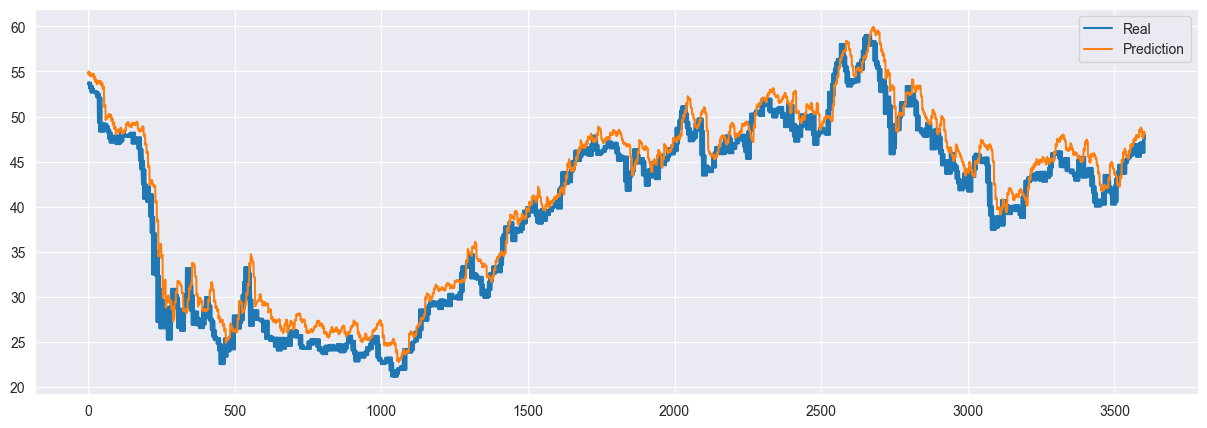

In [52]:
plotEvaluation(testData, predData, columns = testNormDf.columns)

## Ploting The Evaluation

tf.Tensor(13.754706, shape=(), dtype=float32)
tf.Tensor(13.280882, shape=(), dtype=float32)
tf.Tensor(13.354702, shape=(), dtype=float32)
tf.Tensor(13.874284, shape=(), dtype=float32)
tf.Tensor(14.519908, shape=(), dtype=float32)


NameError: name 'columns' is not defined

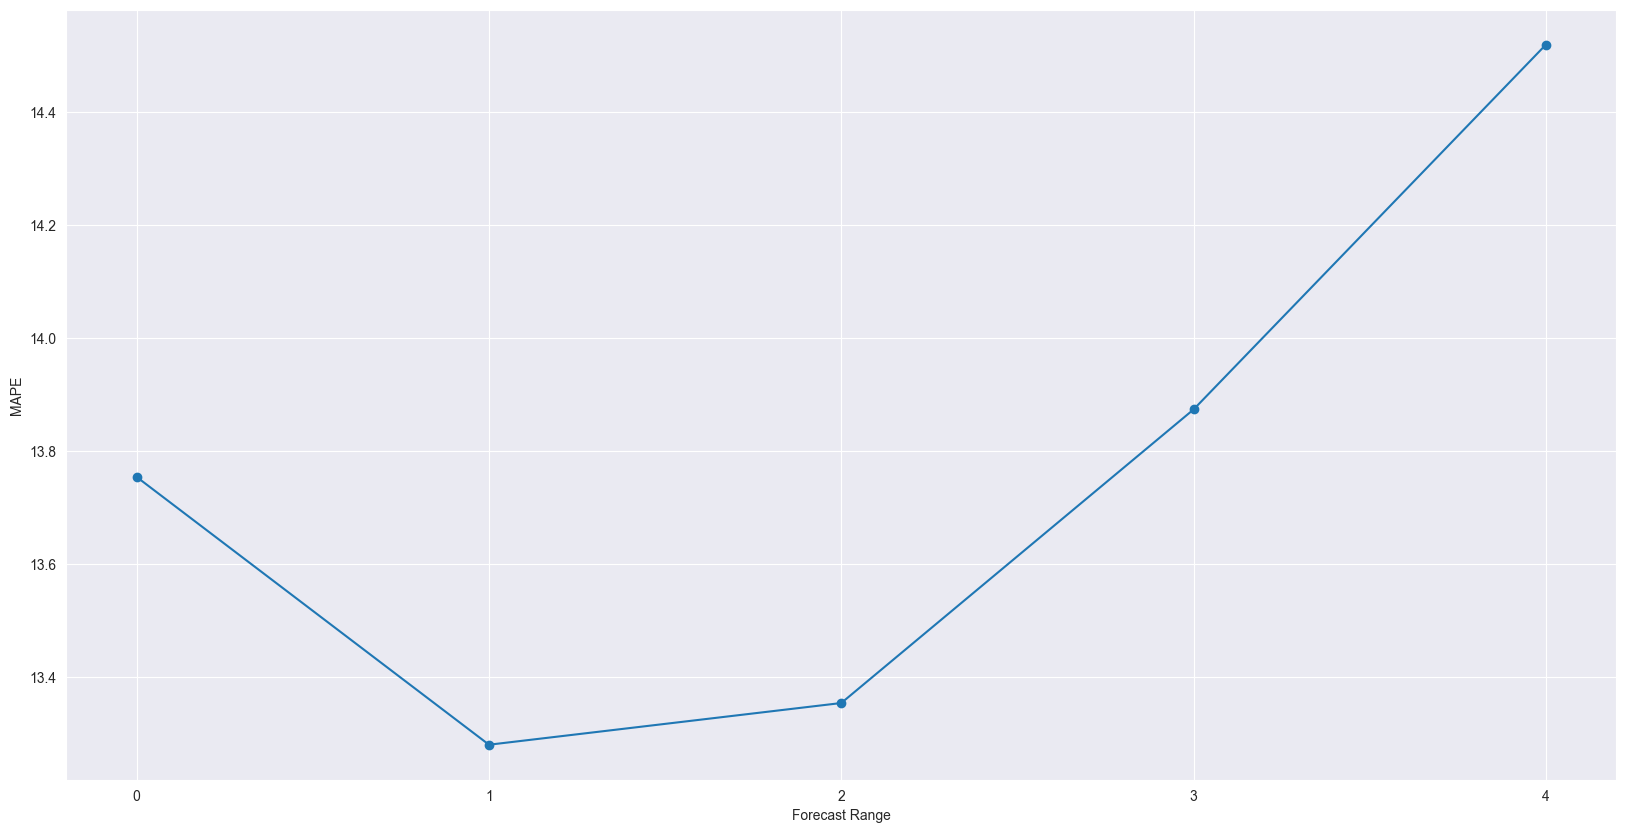

In [64]:
plotMAPEperEpoch(testData, predData)

In [63]:
def displayMetricsByFeatures(testData, predData, columns):
    for i in range(0, len(columns)):
        print('->', columns[i])
        mae = mae_(testData[:,i],predData[:,i])
        print('mae:', mae)
        mse = mse_(testData[:,i],predData[:,i])
        print('mse:', mse)
        mape = mape_(testData[:,i],predData[:,i])
        print('mape:', mape)

In [68]:
displayMetricsByFeatures(testData, predData, train_df.columns)

-> Open
mae: tf.Tensor(1.7125015, shape=(), dtype=float32)
mse: tf.Tensor(4.644582, shape=(), dtype=float32)
mape: tf.Tensor(4.854818, shape=(), dtype=float32)
-> High
mae: tf.Tensor(1.7942806, shape=(), dtype=float32)
mse: tf.Tensor(4.9667144, shape=(), dtype=float32)
mape: tf.Tensor(5.0207543, shape=(), dtype=float32)
-> Low
mae: tf.Tensor(1.6012853, shape=(), dtype=float32)
mse: tf.Tensor(4.5487843, shape=(), dtype=float32)
mape: tf.Tensor(4.5812364, shape=(), dtype=float32)
-> Close
mae: tf.Tensor(1.8759544, shape=(), dtype=float32)
mse: tf.Tensor(5.563423, shape=(), dtype=float32)
mape: tf.Tensor(5.2378197, shape=(), dtype=float32)
-> Adj Close
mae: tf.Tensor(3.339641, shape=(), dtype=float32)
mse: tf.Tensor(13.693286, shape=(), dtype=float32)
mape: tf.Tensor(9.549317, shape=(), dtype=float32)
-> Volume
mae: tf.Tensor(13265001.0, shape=(), dtype=float32)
mse: tf.Tensor(250075610000000.0, shape=(), dtype=float32)
mape: tf.Tensor(53.297432, shape=(), dtype=float32)
